# Part I: Code

In this notebook, the default nside for both beam and sky is 512.

### Sky model implementation
- GSM_maps(freqs, nside=512, beam_window): generate GSM map for given frequencies, return beam-convolved map if beam_window is not None
- SynchrotronExtropolator(): create a sky model using given spectral index map and amplitude map

Example:

    ```python
    Mel_model = SynchrotronExtrapolator()
    mel_sky_RHINO_convolved = Mel_model.map(freq_list, beam_window)
    ```

In [1]:
import healpy as hp
import numpy as np
import glob
from pygdsm import GlobalSkyModel
import matplotlib.pyplot as plt
from fg_model import *
from SEDfitting import *


### Beam object implementation
Usage:
Step 1: Feed in the path to the beam (.fits) files.
Step 2: Generate the beam transfer function with the class method `generate_beam_l`

In [2]:
class RhinoBeam:
    def __init__(self, filepath='/Users/zzhang/Downloads/HornWet/'):
        # read and sort filenames in filepath
        self.filenames = sorted(glob.glob(filepath + '/*.fits'))
        self.nside = hp.get_nside(hp.read_map(self.filenames[0]))

    def get_beam_l(self, normalize=True):
        # Derive the beam transfer function bl as the sqrt of the power spectrum (Cl) of the beam map. 
        # This effectively take the azimuthal average of the beam map
        bl_list = []
        for filename in self.filenames:
            beam = hp.read_map(filename)
            # Compute the power spectrum (Cl) of the beam map
            cl_beam = hp.anafast(beam, lmax=3*self.nside)
            # The beam transfer function bl is the square root of Cl, normalized to bl[0]=1
            bl = np.sqrt(cl_beam)
            if normalize:
                bl /= bl[0]
            bl_list.append(bl)
        self.bl_list = bl_list        

# Part II: running the code

### Load RHINO beam

then azimuthally averaged as the beam transfer function: B_l = sqrt(C_l)

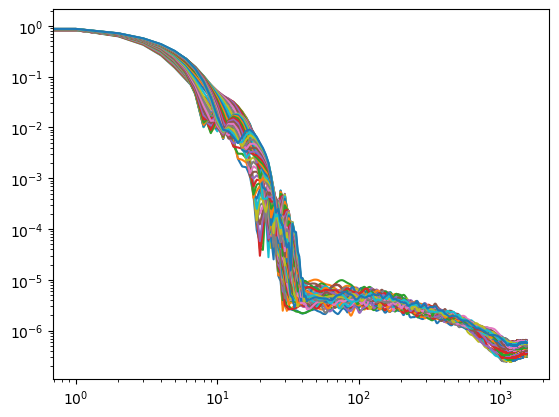

In [3]:
# Generate a list from 55.0 to 85.0, with step be 0.5; include 85.0
freq_list = np.arange(55.0, 85.0+0.5, 0.5)
horn_wet = RhinoBeam(filepath='/Users/zzhang/Downloads/HornWet/')
horn_wet.get_beam_l()
beam_window = horn_wet.bl_list
# plot the bl_list as a list of plots of the bls

plt.plot(np.array(beam_window).T)
plt.yscale('log')
plt.xscale('log')

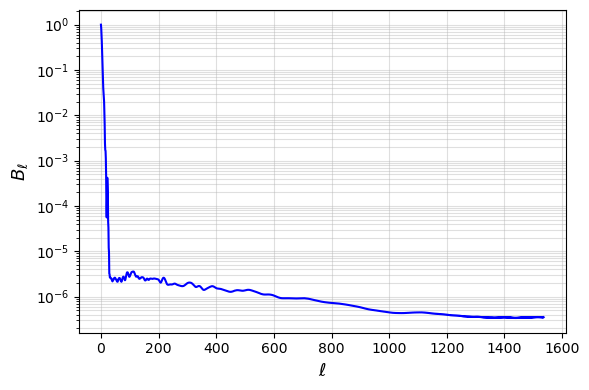

In [4]:
plt.figure(figsize=(6, 4))
ell = np.arange(len(horn_wet.bl_list[0]))
plt.plot(ell, horn_wet.bl_list[0], 'b-', lw=1.5)
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, 500)  # Limit to reasonable ℓ range
plt.grid(True, which='both', alpha=0.4)
plt.xlabel(r'$\ell$', fontsize=13)
plt.ylabel(r'$B_\ell$', fontsize=13)
#plt.title("Beam transfer function", pad=10)
plt.tight_layout()
plt.savefig('beam_transfer_function.pdf')

plt.show()

### Generate beam convolved global diffuse sky model

In [ ]:
Mel_model = SynchrotronExtrapolator()
mel_sky_RHINO_convolved = Mel_model.map(freq_list, beam_window)
GSM_sky_RHINO_convolved = GSM_maps(freq_list, beam_transfer=beam_window)
pivot_specidx_map=Mel_model.specidx_mapl


In [6]:
# hp.mollview(Mel_model.specidx_map, 
#             cmap='plasma',
#             title='')
# plt.tight_layout()
# plt.savefig('spec_ind_map.pdf')

In [7]:
# A boring plot: beam convolved sky..
# hp.mollview(GSM_sky_RHINO_convolved[:,0], norm='log')
# plt.show()

### Creat the spectral basis (and visualize it)

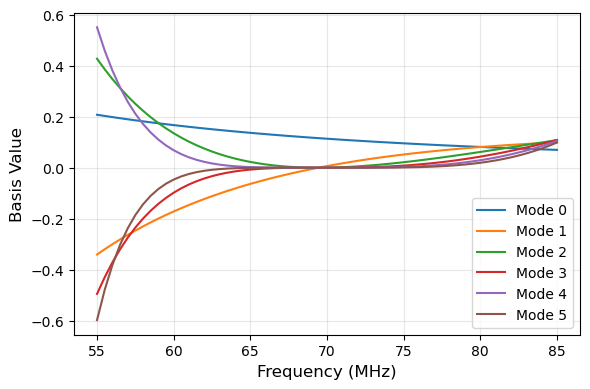

In [8]:

basis_gen = moment_basis(freqs=freq_list)
design_matrix = basis_gen.basis(beta0=-2.5, n_moments=6) 
plt.figure(figsize=(6, 4))
#linestys = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 1))]
for i in range(design_matrix.shape[1]):
    plt.plot(freq_list, design_matrix[:, i], label=f'Mode {i}', 
            #linestyle=linestys[i]
            )
plt.xlabel('Frequency (MHz)', fontsize=12)
plt.ylabel('Basis Value', fontsize=12)
#plt.title('Design Matrix Columns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('derivative_spectra.pdf')  # Save the figure to a file
plt.show()

### Derive the reference frequency for the moment expansion model

68.3739716558867


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_15221/1559926508.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


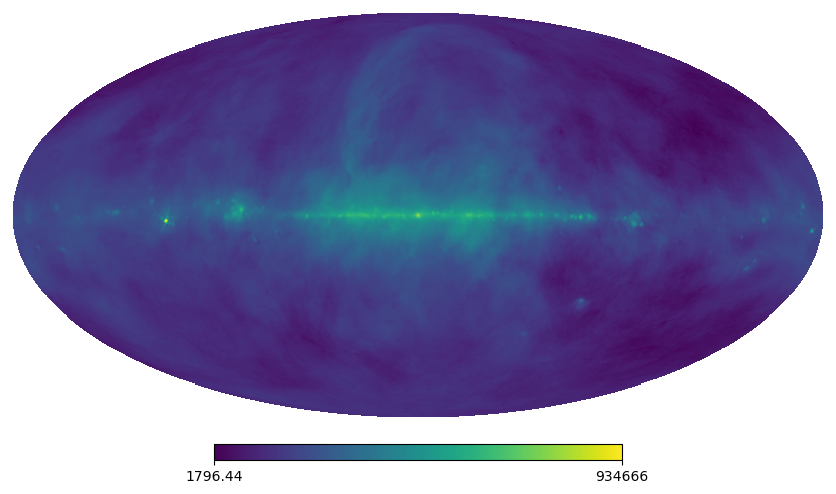

In [9]:
nu_reference = np.exp((np.log(freq_list[0]) + np.log(freq_list[-1]))/2)
print(nu_reference)

# Visualize the intensity of the map at the pivot frequency
hp.mollview(Mel_model.map(nu_reference), 
            cmap='viridis',
            norm='log',
            title='')
plt.tight_layout()
plt.savefig('reference_map.pdf')

### Mel's model: visualise the power-law index ensemble for a given pixel (as an illustrating example of the ensemble)

In [10]:
beam = hp.read_map('/Users/zzhang/Downloads/HornWet/HornWet55.0.fits')
target_lon = 30  # Galactic longitude in degrees
target_lat = 45  # Galactic latitude in degrees
hist, bin_edges = Mel_model.beta_distribution(beam, n_bins=100, rotation=[target_lon, 90+target_lat, 0], show_hist=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

target_pixel_ind = hp.ang2pix(256, np.radians(target_lat), np.radians(target_lon))
pivot_specind = pivot_specidx_map[target_pixel_ind]
print(pivot_specind)

-2.9455123585605727


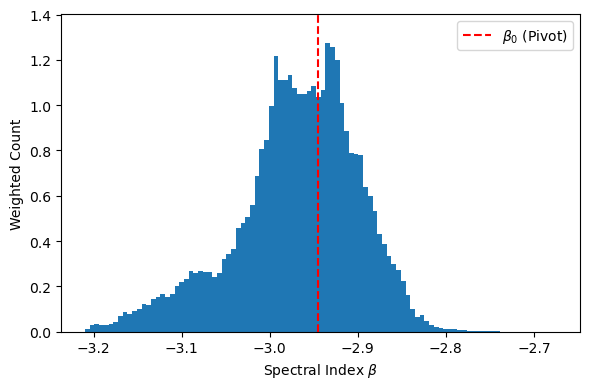

In [11]:
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], align='center')
plt.vlines(x=pivot_specind, ymin=0, ymax=1.1*hist.max(), colors='red', linestyles='dashed', label=r'$\beta_0$ (Pivot)')
# ax = plt.gca()
# ax2 = ax.twiny()  # Create twin axis on top
# ax2.set_xlim(ax.get_xlim())  # Match main axis limits

# # Calculate Δβ labels for top axis
# ticks = ax.get_xticks()
# ax2.set_xticks(ticks)
# ax2.set_xticklabels([f"{x/delta_ln_nu_max+pivot_specind:+.2f}" for x in ticks])
# ax2.set_xlabel(f'Δβ from {pivot_specind:.2f}', fontsize=9)
plt.ylim(0, 1.1*hist.max())
plt.legend()
plt.xlabel(r'Spectral Index $\beta$')
plt.ylabel('Weighted Count')
# plt.title('Beam-weighted Spectral Index Distribution')
# plt.title(r'f($\beta$)')
plt.tight_layout()
plt.savefig('spectral_index_distribution.pdf')



### Understanding the accuracy of moment expansion...

In [12]:
import math
# from ipywidgets import interact, IntSlider, Output  # Add explicit widget imports

def taylor_exp(x, n):
    """Taylor series approximation of e^x up to nth order"""
    return sum([x**k / math.factorial(k) for k in range(n+1)])

# Generate x values from -2 to 2
x = np.linspace(-2, 2, 200)
true_exp = np.exp(x)

delta_ln_nu_max = (np.log(freq_list[-1]) - np.log(freq_list[0])) / 2
xmaxs = (bin_centers - pivot_specind) * delta_ln_nu_max

# @interact(n=IntSlider(value=5, min=0, max=20, step=1, description='Order:'))
# def plot_comparison(n=5):
def plot_comparison(n_list=[3,4,5, 6], savepath=None):
    # Calculate approximation
    approx_list = [np.array([taylor_exp(xi, n) for xi in x]) for n in n_list]
    error_list = [np.abs(true_exp - approx) for approx in approx_list]
    line_style = ['--', '-.', ':', (0, (5, 5))]

    
    # Create plot
    plt.figure(figsize=(9, 9))
    # plt.figure(figsize=(10, 9))
    # gs = plt.GridSpec(4, 1, height_ratios=[3, 3, 2, 3], hspace=0.6) 
    # gs_top = gs[0:3].subgridspec(3, 1, hspace=0)
    gs_top = plt.GridSpec(3, 1, height_ratios=[3, 3, 2], hspace=0) 
    
    # Plot functions
    ax1 = plt.subplot(gs_top[0])
    plt.plot(x, true_exp, label=r'True $e^x$', color='gray', linewidth=3, alpha=0.5)
    for i in range(len(n_list)):
        plt.plot(x, approx_list[i], linestyle=line_style[i], label=f'Taylor (n={n_list[i]})')
    plt.ylabel('Value')
    #plt.xlabel('x')
    plt.setp(ax1.get_xticklabels(), visible=False)  
    plt.legend()
    
    # Plot error
    ax2 = plt.subplot(gs_top[1], sharex=ax1)
    for i in range(len(n_list)):
        plt.semilogy(x, error_list[i], linestyle=line_style[i], label=f'Error (n={n_list[i]})')
    # plt.semilogy(x, np.abs(true_exp - approx))
    plt.ylabel('Absolute Error')
    plt.setp(ax1.get_xticklabels(), visible=False)  
    #plt.xlabel('x')
    ax3 = plt.subplot(gs_top[2], sharex=ax1)
    plt.bar(xmaxs, hist, width=bin_edges[1]-bin_edges[0], align='center', color='gray', alpha=0.5)
    plt.yscale('log')
    plt.ylabel('Weight')
    plt.xlabel('x')


    # ax4 = plt.subplot(gs[3])
    # plt.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], align='center')
    # plt.vlines(x=pivot_specind, ymin=0, ymax=1.1*hist.max(), colors='red', linestyles='dashed', label=r'$\beta_0$ (Pivot)')
    # # ax = plt.gca()
    # # ax2 = ax.twiny()  # Create twin axis on top
    # # ax2.set_xlim(ax.get_xlim())  # Match main axis limits
    
    # # # Calculate Δβ labels for top axis
    # # ticks = ax.get_xticks()
    # # ax2.set_xticks(ticks)
    # # ax2.set_xticklabels([f"{x/delta_ln_nu_max+pivot_specind:+.2f}" for x in ticks])
    # # ax2.set_xlabel(f'Δβ from {pivot_specind:.2f}', fontsize=9)
    # plt.ylim(0, 1.1*hist.max())
    # plt.legend()
    # plt.xlabel(r'Spectral Index $\beta$')
    # plt.ylabel('Weighted Count')
    # plt.title('Beam-weighted Spectral Index Distribution')
    
    # plt.subplots_adjust(top=0.93, bottom=0.12, 
    #                    hspace=0.6)  

    #plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()



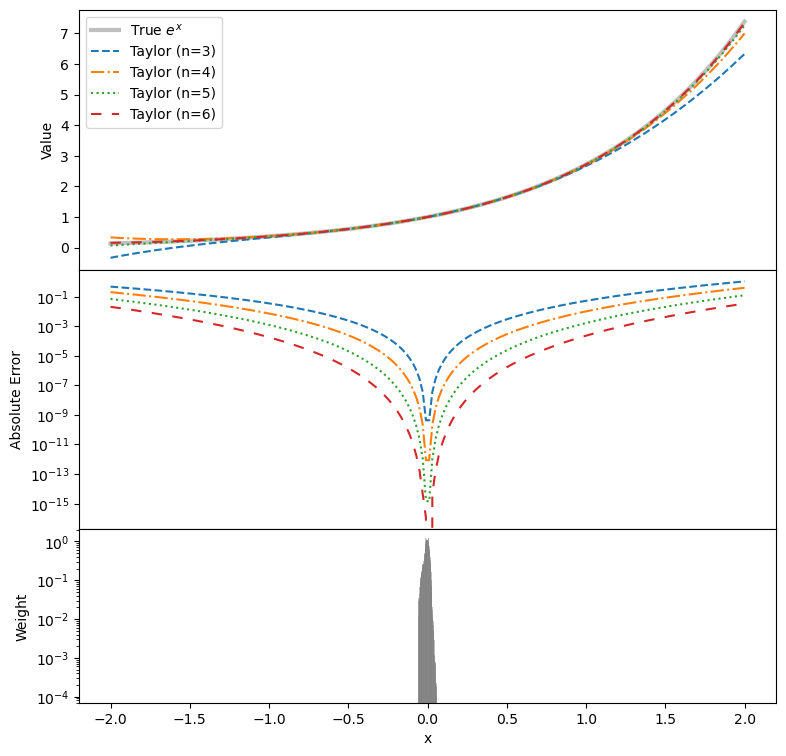

In [13]:
plot_comparison(savepath='expansion_plot.pdf')

Mel_moment_coeffs_maps_5_fixed, Mel_loss_map_5_fixed = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, max_order=5, fixed_pivot=True)

### Fitting with fixed pivot values (up to the 5th moment)

In [29]:
Mel_moment_coeffs_maps_4_fixed, Mel_loss_map_4_fixed = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, max_order=4, fixed_pivot=True)

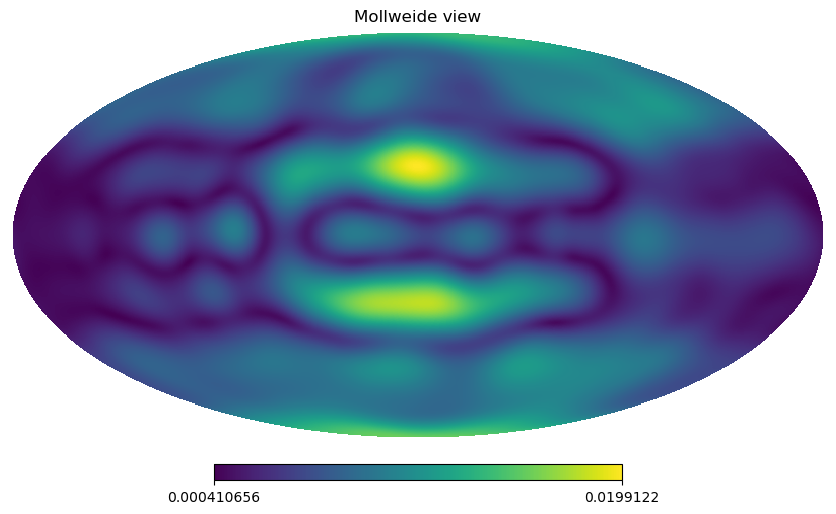

In [30]:
hp.mollview(Mel_loss_map_4_fixed)

### Fitting with adapted pivot values (up to the 5th moment)

In [16]:
Mel_moment_coeffs_maps_5_adapted, Mel_loss_map_5_adapted = fit_entire_map(mel_sky_RHINO_convolved, pivot_specidx_map, freq_list, nu_ref=None, max_order=5, fixed_pivot=False)

Processing pixels:   0%|          | 0/3145728 [00:00<?, ?it/s]/Users/zzhang/Workspace/MERS/SEDfitting.py:210: RuntimeWarning: overflow encountered in exp
  xs_beta0 = np.exp(self.log_xs*beta0)
/opt/homebrew/Caskroom/miniconda/base/envs/21cmvae/lib/python3.10/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/zzhang/Workspace/MERS/SEDfitting.py:217: RuntimeWarning: invalid value encountered in divide
  result /= norms[np.newaxis, :]  # Normalize each column by its l2-norm
/Users/zzhang/Workspace/MERS/SEDfitting.py:210: RuntimeWarning: overflow encountered in exp
  xs_beta0 = np.exp(self.log_xs*beta0)
/opt/homebrew/Caskroom/miniconda/base/envs/21cmvae/lib/python3.10/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/Users/zzhang/Workspace/MERS/SEDfitting.py:217: RuntimeWarning: invalid value encountered in divide
  result /= norms[np.newaxis, :]  #

In [ ]:
hp.mollview(Mel_loss_map_5_adapted, title='Ratio of loss')

NameError: name 'hp' is not defined

### Visualise the residual error maps

In [18]:

# Generate a figure with 6 subplots, with the layout as 3 rows and 2 columns.
# The first row are healmaps of Mel_loss_map_3 and GSM_loss_map_3, with the same colorbar.
# The second row are healmaps of Mel_loss_map_4 and GSM_loss_map_4, with the same colorbar.
# The third row are healmaps of Mel_loss_map_5 and GSM_loss_map_5, with the same colorbar.

def plot_loss_comparison(savepath=None):
    plt.figure(figsize=(14, 18))
    
    maps = [
        (Mel_loss_map_3, GSM_loss_map_3, '3 Modes'),
        (Mel_loss_map_4, GSM_loss_map_4, '4 Modes'), 
        (Mel_loss_map_5, GSM_loss_map_5, '5 Modes'),
        (Mel_loss_map_6, GSM_loss_map_6, '6 Modes')
    ]
    titles = ['Mel', 'GSM', '']
    
    gs = plt.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1,1,1, 1], wspace=0.01)
    
    for row in range(4):
        map1, map2, label = maps[row]
        
        vmin = min(np.nanpercentile(map1, 1), np.nanpercentile(map2, 1))
        vmax = max(np.nanpercentile(map1, 99), np.nanpercentile(map2, 99))
        
        cbar='bwr'
        ax1 = plt.subplot(gs[row, 0], projection='mollweide')
        im1 = hp.mollview(map1, title='', hold=True, 
                          #min=vmin, max=vmax, 
                          #norm='log',
                          cmap=cbar)
        plt.text(0.5, 1.1, f'{titles[0]} {label}', 
                ha='center', va='bottom', transform=ax1.transAxes, fontsize=12)
        
        ax2 = plt.subplot(gs[row, 1], projection='mollweide')
        im2 = hp.mollview(map2, title='', hold=True, 
                          #min=vmin, max=vmax, 
                          #norm='log',
                          cmap=cbar)
        plt.text(0.5, 1.1, f'{titles[1]} {label}', 
                ha='center', va='bottom', transform=ax2.transAxes, fontsize=12)
        
        # cax = plt.subplot(gs[row, 2])
        # plt.colorbar(im1['cmap'], cax=cax).set_label('Loss Value', fontsize=10)
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.suptitle('Spectral Moment Fitting Error Comparison', y=0.93, fontsize=14)
    plt.show()

# plot_loss_comparison(savepath='./loss_comparison.pdf')

### Visualise the moment maps

In [19]:

def plot_moment_maps(savepath=None):
    plt.figure(figsize=(16, 16))
    

    titles = [['Mel']*6, ['GSM']*6]
    
    gs = plt.GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1,1,1,1], wspace=0.01)
    
    for row in range(2):
        for col in range(3):
            ind=row*3+col
            map=Mel_moment_coeffs_maps_6[:,ind]
        
            if ind==0:
                # not using diverging colormap
                cbar='bwr'
            else:
                # using diverging colormap
                cbar='bwr'
            ax1 = plt.subplot(gs[row, col], projection='mollweide')
            im1 = hp.mollview(map, title='', hold=True, 
                            #min=vmin, max=vmax, 
                            #norm='log',
                            cmap=cbar)
            plt.text(0.5, 1.1, f'{titles[0][ind]} Mode {ind}', 
                    ha='center', va='bottom', transform=ax1.transAxes, fontsize=14)

    for row in range(2):
        for col in range(3):
            ind=row*3+col
            map=GSM_moment_coeffs_maps_6[:,ind]
        
            if ind==0:
                # not using diverging colormap
                cbar='bwr'
            else:
                # using diverging colormap
                cbar='bwr'
            ax1 = plt.subplot(gs[row+2, col], projection='mollweide')
            im1 = hp.mollview(map, title='', hold=True, 
                            #min=vmin, max=vmax, 
                            #norm='log',
                            cmap=cbar)
            plt.text(0.5, 1.1, f'{titles[1][ind]} Mode {ind}', 
                    ha='center', va='bottom', transform=ax1.transAxes, fontsize=14)

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    #plt.suptitle('Spectral Moment Fitting Error Comparison', y=0.93, fontsize=14)
    plt.show()

# plot_moment_maps()

In [20]:
# plot_moment_maps(savepath='moment_maps.pdf')